# Character-Level Tokenization and Embeddings

This notebook demonstrates character-level tokenization and embeddings using the Shakespeare dataset.

In [1]:
import torch
import numpy as np
from pathlib import Path

## Load and Inspect the Data

In [2]:
# Read the Shakespeare text
with open('../data/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of dataset in characters: {len(text)}')
print('\nFirst 1000 characters:\n')
print(text[:1000])

Length of dataset in characters: 1115394

First 1000 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods k

## Character-Level Tokenization

In character-level tokenization, each unique character in the text becomes a token. This is the simplest form of tokenization.

In [3]:
# Get all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f'Vocabulary size (unique characters): {vocab_size}')
print('\nAll characters:', ''.join(chars))

Vocabulary size (unique characters): 65

All characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
# Create mappings from characters to integers and back
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Example: encode and decode some text
example_text = "Hello, World!"
encoded = [char_to_idx[ch] for ch in example_text]
decoded = ''.join([idx_to_char[idx] for idx in encoded])

print(f'Original text: {example_text}')
print(f'Encoded: {encoded}')
print(f'Decoded: {decoded}')

Original text: Hello, World!
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: Hello, World!


## Character Embeddings

Now we'll create character embeddings. Each character will be represented by a vector in a higher-dimensional space.

In [7]:
# Parameters for embeddings
embedding_dim = 8  # Dimension of the embedding space

# Create a random embedding table
embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

# Example: get embeddings for a sequence of characters
example_sequence = torch.tensor(encoded)  # Using the encoded text from above
embedded_sequence = embeddings(example_sequence)

print(f'Shape of embedded sequence: {embedded_sequence.shape}')
print('\nEmbedding for first character:')
print(embedded_sequence[0].detach().numpy())

Shape of embedded sequence: torch.Size([13, 8])

Embedding for first character:
[-0.1935678   0.58584267 -2.5107687  -1.1470561  -1.3911767   2.0416408
  0.5066091   1.4253821 ]


## Visualizing Embeddings

We can visualize the learned embeddings by projecting them to 2D using PCA.

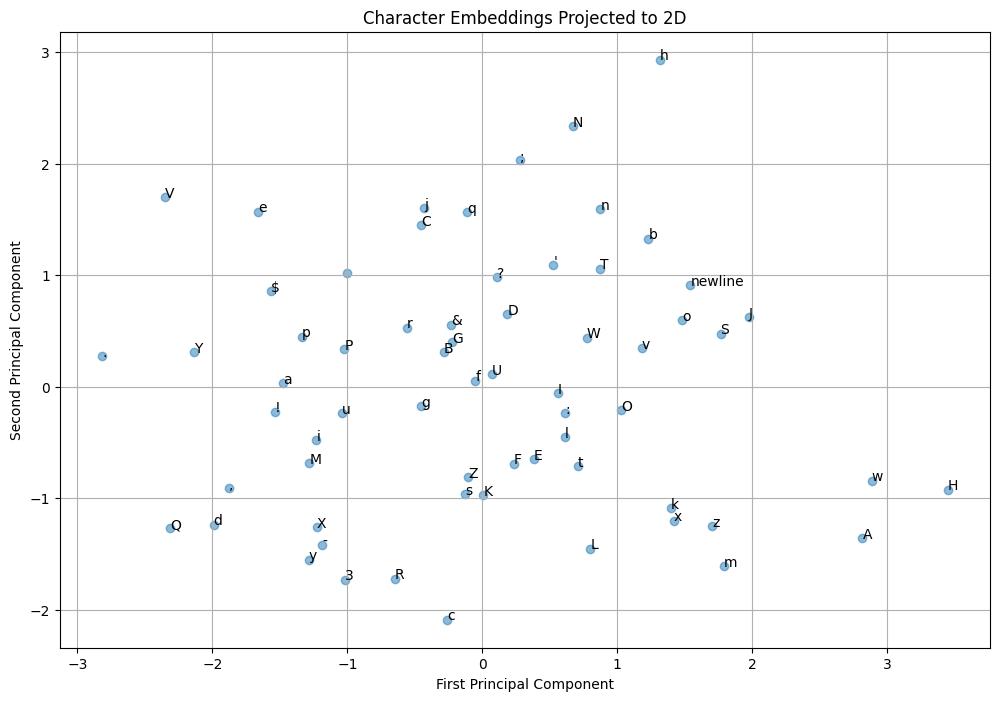

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the embedding weights
weights = embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(weights)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Train Embedding function

In [9]:
# Example of how we create training pairs
def show_data_preparation_example():
    # Take a small sample of text
    sample_text = "Hello, World!"
    print(f"Sample text: {sample_text}")
    
    # Convert to indices
    indices = [char_to_idx[ch] for ch in sample_text]
    context_size = 2
    
    print("\nCreating context windows (context_size=2):")
    print("Center char | Context chars (2 before, 2 after)")
    print("-" * 45)
    
    # Show some examples
    for i in range(context_size, len(indices) - context_size):
        center_char = sample_text[i]
        context_chars = (
            sample_text[i-context_size:i] + '*' +
            sample_text[i+1:i+context_size+1]
        )
        
        print(f"    {center_char}     | {context_chars}")
        
    print("\nThese will be converted to tensor indices for training.")
    
# Run the example
show_data_preparation_example()

Sample text: Hello, World!

Creating context windows (context_size=2):
Center char | Context chars (2 before, 2 after)
---------------------------------------------
    l     | He*lo
    l     | el*o,
    o     | ll*, 
    ,     | lo* W
          | o,*Wo
    W     | , *or
    o     |  W*rl
    r     | Wo*ld
    l     | or*d!

These will be converted to tensor indices for training.


In [10]:
# Convert text to indices tensor
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

print(f"Shape of data tensor: {data.shape}")
print(f"First 20 characters as indices: {data[:20]}")
print(f"As characters: {''.join([idx_to_char[idx.item()] for idx in data[:20]])}")

Shape of data tensor: torch.Size([1115394])
First 20 characters as indices: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])
As characters: First Citizen:
Befor


In [130]:
# Model parameters
embedding_dim = 16
context_size = 2
batch_size = 512
learning_rate = 0.001

In [131]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SkipgramDataset(Dataset):
    def __init__(self, data, context_size):
        self.data = data
        self.context_size = context_size
        self.pairs = []
        
        # Create training pairs
        for i in range(context_size, len(data) - context_size):
            center = data[i]
            context = torch.cat([
                data[i-context_size:i],
                data[i+1:i+context_size+1]
            ])
            self.pairs.append((center, context))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return center, context

# Create dataset and dataloader
dataset = SkipgramDataset(data, context_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

Number of training examples: 1,115,390
Number of batches: 2,179


# 1. Simplest approach

In [132]:
import torch
import torch.nn as nn

class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Embedding layer for context characters
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Output layer to predict center character
        self.output = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, center_chars, context_chars):
        # Get embeddings for context characters
        context_embeds = self.embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Average context embeddings
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embedding_dim]
        
        # Predict center character
        logits = self.output(context_embeds)  # [batch_size, vocab_size]
        
        return logits

In [133]:
# Initialize model, optimizer, and loss function
model = CharacterEmbedding(vocab_size, embedding_dim)

# Use AdamW optimizer with weight decay for better regularization
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate)

# Keep using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

In [134]:
# Training loop
n_epochs = 10
losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    with tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

Epoch 10/10: 100%|██████████████████████| 2179/2179 [00:04<00:00, 448.20it/s, loss=2.3567]


# 2. Add a hidden layer 

In [182]:
logits[0]

tensor([ 5.7600e-01,  4.5764e+00, -2.0626e+01, -8.3890e+01, -6.9802e+01,
        -2.6310e-01, -9.7145e+00, -7.5426e-01, -3.5990e+01, -9.9215e+01,
        -1.6958e+01, -1.2452e+01, -2.3844e+01, -1.3193e+01, -9.9521e+00,
        -9.0588e+00, -1.7257e+01, -1.1690e+01, -1.0714e+01, -1.1333e+01,
        -1.4873e+01, -4.0142e+01, -1.1381e+01, -3.2340e+01, -9.3326e+00,
        -9.9176e+00, -8.5744e+00, -2.5573e+01, -8.9265e+00, -7.1132e+01,
        -7.4240e+00, -7.8560e+00, -1.3733e+01, -2.2610e+01, -1.8723e+01,
        -1.2920e+01, -1.4154e+02, -2.8552e+01, -5.2038e+01,  2.6265e+00,
        -2.0174e+00, -5.1968e-01, -4.4291e-01,  3.1326e+00, -1.5589e+00,
        -1.6183e+00,  1.6451e+00,  1.8758e+00, -5.9929e+00, -3.4913e+00,
        -5.5774e-02,  7.0663e-01,  1.1202e+00,  2.1470e+00, -7.7175e-01,
        -4.1890e+01,  1.4880e+00,  1.2918e+00,  4.5528e-01,  1.7649e+00,
        -5.1423e+00, -3.4959e-01, -4.4666e+00, -2.5870e+00, -4.8074e+00])

In [162]:
center

tensor([39, 58,  6, 57, 58,  0,  8, 43, 43, 53, 44, 57, 43, 13,  5, 54, 52, 50,
        18,  1, 42, 42, 42, 61, 47, 13,  0, 52, 58, 18, 58, 53,  0, 46,  1, 43,
         1, 17, 43, 50, 30, 51, 47, 27, 61,  1, 47,  1,  1, 60, 49, 57,  1, 39,
        53, 56, 44, 24, 53, 40, 50, 47, 32, 58, 43, 46,  6, 53, 31,  1, 11, 58,
        13, 42, 53,  0,  2, 57, 57, 61,  1, 31, 59, 56, 46,  6, 50,  6, 52,  6,
        56, 57, 39, 57,  1, 46, 21, 46, 43,  1,  1, 53, 56, 30, 50, 43, 51, 61,
        15, 53,  1,  1, 58, 56, 63, 58,  1, 56,  1, 42, 57, 58, 53, 53,  1,  1,
        11,  0,  1, 40,  1, 46,  0, 43, 41, 53, 44, 35, 47, 50, 56, 42, 52, 54,
        52, 53, 43, 44, 59,  0,  0,  1, 41, 50, 47,  1,  1, 43, 61,  1, 57, 46,
        53,  0, 52, 15, 46, 17, 43,  1,  6, 39, 56,  6, 41, 46, 63, 46, 39, 45,
        63, 51, 17, 46, 48, 13,  1, 57,  8, 24, 56,  1, 57, 14, 45, 52, 10, 42,
        56, 51, 58, 57,  1,  0, 61, 43, 54, 53, 59, 43, 17,  6, 57, 43,  1, 40,
        17, 57, 63, 57, 59, 41,  1, 53, 

In [146]:
class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=64):
        super().__init__()
        
        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Add batch normalization for better training stability
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        
        # Hidden layers
        self.hidden = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)  # Add dropout for regularization
        )
        
        # Output layer to predict center character
        self.output = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, center_chars, context_chars):
        # Get embeddings for context characters
        context_embeds = self.embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Average context embeddings
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embedding_dim]
        context_embeds = self.batch_norm(context_embeds)
        
        # Pass through hidden layers
        hidden = self.hidden(context_embeds)  # [batch_size, hidden_dim]
        
        # Predict center character
        logits = self.output(hidden)  # [batch_size, vocab_size]
        
        return logits

In [176]:
# Initialize model, optimizer, and loss function
model = CharacterEmbedding(vocab_size, embedding_dim)

# Use AdamW optimizer with weight decay for better regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

In [177]:
# Training loop
n_epochs = 10
losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    with tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

Epoch 10/10: 100%|████████████| 2179/2179 [00:05<00:00, 363.49it/s, loss=2.1841]


Epoch 1/20: 100%|███████| 1961/1961 [00:05<00:00, 345.67it/s, train_loss=2.3347]


Epoch 1/20
  Train Loss: 2.1364
  Val Loss: 2.0351


Epoch 2/20: 100%|███████| 1961/1961 [00:05<00:00, 377.15it/s, train_loss=2.0621]


Epoch 2/20
  Train Loss: 2.1320
  Val Loss: 2.0329


Epoch 3/20: 100%|███████| 1961/1961 [00:05<00:00, 381.54it/s, train_loss=1.9965]


Epoch 3/20
  Train Loss: 2.1303
  Val Loss: 2.0288


Epoch 4/20: 100%|███████| 1961/1961 [00:05<00:00, 384.13it/s, train_loss=2.1122]


Epoch 4/20
  Train Loss: 2.1277
  Val Loss: 2.0263


Epoch 5/20: 100%|███████| 1961/1961 [00:05<00:00, 372.94it/s, train_loss=2.2213]


Epoch 5/20
  Train Loss: 2.1256
  Val Loss: 2.0248


Epoch 6/20: 100%|███████| 1961/1961 [00:05<00:00, 371.42it/s, train_loss=2.2641]


Epoch 6/20
  Train Loss: 2.1228
  Val Loss: 2.0217


Epoch 7/20: 100%|███████| 1961/1961 [00:05<00:00, 355.35it/s, train_loss=1.9346]


Epoch 7/20
  Train Loss: 2.1217
  Val Loss: 2.0203


Epoch 8/20: 100%|███████| 1961/1961 [00:05<00:00, 347.92it/s, train_loss=2.1695]


Epoch 8/20
  Train Loss: 2.1191
  Val Loss: 2.0195


Epoch 9/20: 100%|███████| 1961/1961 [00:05<00:00, 385.32it/s, train_loss=2.0215]


Epoch 9/20
  Train Loss: 2.1187
  Val Loss: 2.0154


Epoch 10/20: 100%|██████| 1961/1961 [00:05<00:00, 392.01it/s, train_loss=2.1261]


Epoch 10/20
  Train Loss: 2.1163
  Val Loss: 2.0131


Epoch 11/20: 100%|██████| 1961/1961 [00:05<00:00, 378.83it/s, train_loss=2.0669]


Epoch 11/20
  Train Loss: 2.1145
  Val Loss: 2.0128


Epoch 12/20: 100%|██████| 1961/1961 [00:05<00:00, 391.50it/s, train_loss=2.0431]


Epoch 12/20
  Train Loss: 2.1141
  Val Loss: 2.0125


Epoch 13/20: 100%|██████| 1961/1961 [00:05<00:00, 376.69it/s, train_loss=2.1762]


Epoch 13/20
  Train Loss: 2.1117
  Val Loss: 2.0090


Epoch 14/20: 100%|██████| 1961/1961 [00:04<00:00, 397.12it/s, train_loss=2.0183]


Epoch 14/20
  Train Loss: 2.1117
  Val Loss: 2.0080


Epoch 15/20: 100%|██████| 1961/1961 [00:05<00:00, 380.06it/s, train_loss=2.1754]


Epoch 15/20
  Train Loss: 2.1106
  Val Loss: 2.0091


Epoch 16/20: 100%|██████| 1961/1961 [00:05<00:00, 370.28it/s, train_loss=2.1273]


Epoch 16/20
  Train Loss: 2.1094
  Val Loss: 2.0066


Epoch 17/20: 100%|██████| 1961/1961 [00:05<00:00, 367.29it/s, train_loss=1.9264]


Epoch 17/20
  Train Loss: 2.1099
  Val Loss: 2.0072


Epoch 18/20: 100%|██████| 1961/1961 [00:05<00:00, 377.85it/s, train_loss=2.0025]


Epoch 18/20
  Train Loss: 2.1083
  Val Loss: 2.0063


Epoch 19/20: 100%|██████| 1961/1961 [00:05<00:00, 335.71it/s, train_loss=2.2084]


Epoch 19/20
  Train Loss: 2.1077
  Val Loss: 2.0067


Epoch 20/20: 100%|██████| 1961/1961 [00:05<00:00, 364.63it/s, train_loss=2.1763]


Epoch 20/20
  Train Loss: 2.1072
  Val Loss: 2.0042


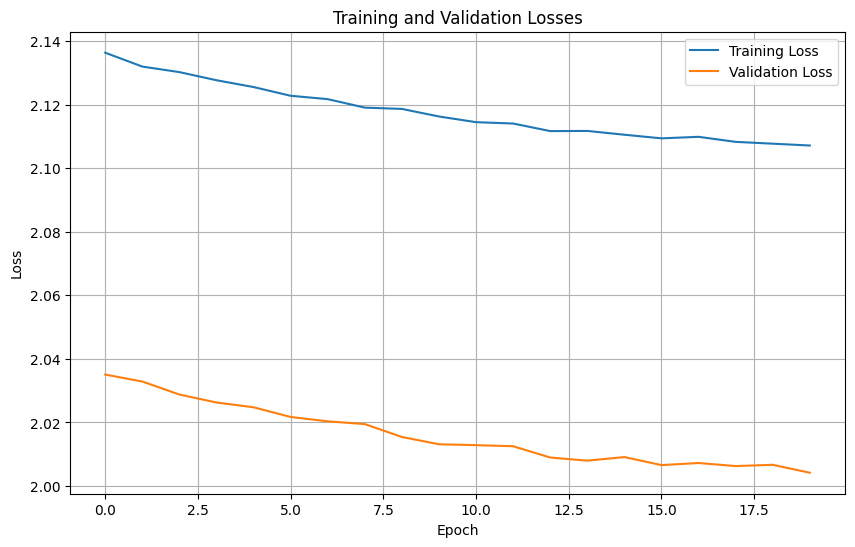

In [179]:
# Split data into train and validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop with validation
n_epochs = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0
    num_train_batches = len(train_dataloader)
    
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    num_val_batches = len(val_dataloader)
    
    with torch.no_grad():
        for center, context in val_dataloader:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    
    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_char_embeddings.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Val Loss: {avg_val_loss:.4f}')

# Load best model
model.load_state_dict(torch.load('best_char_embeddings.pt'))

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [151]:
# Check new embeddings

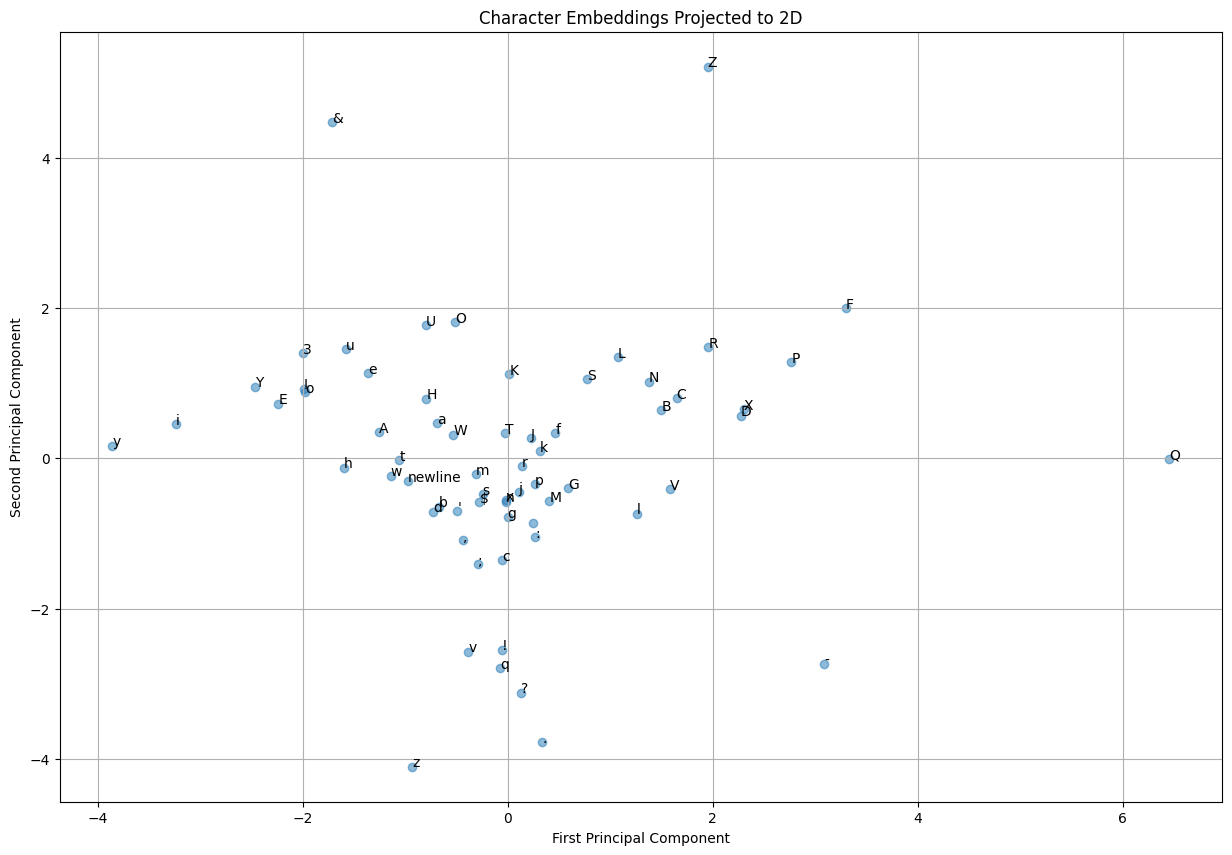

In [181]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the trained embeddings (we use the main embeddings, not the context ones)
trained_embeddings = model.embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(trained_embeddings)

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Now, train a model to produce Text

## Creating Training Examples

Let's see how to create training examples for a language model. Each example will consist of a sequence of characters and the next character as the target.

In [ ]:
# Convert entire text to indices
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

# Create sequences of context_length characters
context_length = 4
x = torch.stack([data[i:i+context_length] for i in range(len(data)-context_length)])
y = data[context_length:]

print(f'Shape of input sequences: {x.shape}')
print(f'Shape of target values: {y.shape}')

# Show an example
idx = 0  # First sequence
context = ''.join([idx_to_char[int(i)] for i in x[idx]])
next_char = idx_to_char[int(y[idx])]
print(f'\nExample:')
print(f'Context: "{context}"')
print(f'Next character: "{next_char}"')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CharacterLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        embedded = self.embeddings(x)  # (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, sequence_length, hidden_dim)
        logits = self.fc(lstm_out)  # (batch_size, sequence_length, vocab_size)
        return logits

# Model parameters
embedding_dim = 16
hidden_dim = 32
context_length = 16
batch_size = 128

# Initialize model
model = CharacterLM(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, context_length):
        self.data = data
        self.context_length = context_length
    
    def __len__(self):
        return len(self.data) - self.context_length - 1
    
    def __getitem__(self, idx):
        # Get input sequence and target
        x = self.data[idx:idx + self.context_length]
        y = self.data[idx + 1:idx + self.context_length + 1]
        return x, y

# Create dataset and dataloader
dataset = TextDataset(data, context_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

In [ ]:
from tqdm.notebook import tqdm

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for x, y in tqdm(dataloader, desc='Training'):
        # Forward pass
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Training parameters
n_epochs = 5

# Train the model
losses = []
for epoch in range(n_epochs):
    loss = train_epoch(model, dataloader, optimizer, criterion)
    losses.append(loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def generate_text(model, start_text, max_length=200, temperature=1.0):
    model.eval()
    
    # Convert start text to indices
    context = torch.tensor([char_to_idx[ch] for ch in start_text])
    generated_text = start_text
    
    for _ in range(max_length):
        # Get model predictions
        x = context[-context_length:].unsqueeze(0)  # Add batch dimension
        logits = model(x)
        probs = F.softmax(logits[0, -1] / temperature, dim=0)
        
        # Sample next character
        next_idx = torch.multinomial(probs, 1).item()
        next_char = idx_to_char[next_idx]
        
        # Update context and generated text
        generated_text += next_char
        context = torch.cat([context, torch.tensor([next_idx])])
    
    return generated_text

# Generate some text
start_texts = [
    "To be, or not to be",
    "Romeo, Romeo",
    "Friends, Romans, countrymen"
]

for start_text in start_texts:
    print(f'\nPrompt: "{start_text}"')
    print('Generated:')
    print(generate_text(model, start_text, temperature=0.8))
    print('-' * 80)